# Visualizing Dvorak

## Scraping the data from IMSLP

In [1]:
import requests
import pandas as pd
import re
from bs4 import BeautifulSoup

url = "https://imslp.org/wiki/List_of_works_by_Anton%C3%ADn_Dvo%C5%99%C3%A1k"
page = requests.get(url)
soup = BeautifulSoup(page.text, 'html.parser')

In [2]:
table = soup.find("table")
table_text = []

for row in table.findAll("tr"):
    cells = row.findAll(["th", "td"])
    # Remove new line from each string in the process
    cell_contents = [cell.text.replace("\n", "") for cell in cells]
    table_text.append(cell_contents)
raw_works = pd.DataFrame(table_text[1:], columns = table_text[0])
raw_works.head()

,B.,Op.,Title,Forces,Key,Date,Genre,Notes
0,001,—,Forget-me-not Polka (Polka pomněnka),pf,C major,1854–65?,Keyboard,trio composed by A. Liehmann
1,002,—,Mass,,B♭ major,1857–59?,Vocal,lost
2,003,—,Polka,pf,E major,1860,Keyboard,doubtful
3,004,—,The Woman Harpist (Harfenice),orch,,1862–64?,Orchestral,polka; lost
4,005,—,Polka,orch,,1861–62?,Orchestral,lost


In [3]:
raw_works.tail()

,B.,Op.,Title,Forces,Key,Date,Genre,Notes
592,603/15,—,The Cherries Grow Ripe in the Field (V poli z...,fch,,1883,Vocal,
593,603/16,—,"O, the Black Raven is Walking (Oj, kráče havr...",fch,,1883,Vocal,
594,604,—,"Ah, Such Love (Ha, ta láska)",ten orch,,1884?,Vocal,arr. of the song by Josef Lev
595,605,—,The Old Folks at Home (Staré budou doma)ameer,sop bbar ch orch,,1893–94?,Vocal,arr. of the Variations on 'Old Folks at Home'...
596,606,—,Forthwith Polka (Vysoká polka),v pf,,1902,Keyboard,arrangement of a traditional Czech song


In [4]:
raw_works.shape

(597, 8)

## Clean the raw data

In [5]:
df = raw_works.copy()
df.columns = [column.lower() for column in df.columns]
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [6]:
# ONLY consider compositions with Opus number
df = df[(df['op.'] != '—') & (df['op.'] != '')]
df.head()

,b.,op.,title,forces,key,date,genre,notes
6,007,001,String Quintet No.1,2vn 2va vc,A minor,1861,Chamber,
7,008,002,String Quartet No.1,2vn va vc,A major,1862,Chamber,
29,012,004,Symphony No.2,orch,B♭ major,"1865, rev.1887",Orchestral,
57,024,005,The Orphan (Sirotek),v pf,,1871,Vocal,
59,025,013/1,Piano Trio (Klavírní trio),vn vc pf,,1871–72,Chamber,lost


get rid of these header-subheader type rows

In [7]:
if len(df[df["date"] == ""]) !=0:
    df = df[df["date"] != ""]

In [8]:
if len(df[df["key"] == ""]) != 0:
    df = df[df["key"] != ""]

Key

In [9]:
sorted(df["key"].unique())

['A major',
 'A minor',
 'A♭ major',
 'A♭ minor',
 'B major',
 'B minor',
 'B♭ major',
 'B♭ major–B♭ minor',
 'B♭ minor',
 'C major',
 'C minor',
 'C♯ minor',
 'D major',
 'D minor',
 'D♭ major',
 'D♭ minor',
 'E major',
 'E minor',
 'E♭ major',
 'E♭ minor',
 'F major',
 'F minor',
 'F♯ minor',
 'G major',
 'G major–E minor',
 'G major–G minor',
 'G minor',
 'G♭ major']

Add another column of mode (either major or minor)

In [10]:
def decide_key(key):
    if "major" in key:
        if "minor" not in key:
            return "major"
        else:
            return "other"
    elif "minor" in key:
        if "major" not in key:
            return "minor"
        else:
            return "other"
    else:
        return None
df["mode"] = df["key"].apply(decide_key)

Date: always a tedious work in data cleaning

In [11]:
df["date"].min(), df["date"].max()

('1861', '1895')

In [12]:
df = df[~df["date"].str.contains("\?")]

In [13]:
df = df[df["date"].apply(lambda x: bool(re.search("[0-9]", x)))]
df["date"].min(), df["date"].max()

('1861', '1895')

In [14]:
df["min_date"] = df["date"].apply(lambda x: x.split("–")[0] if "–" in x else x)
# Need to add the first two characters for second part of range
df["max_date"] = df["date"].apply(lambda x: x[0:2] + x.split("–")[1] if "–" in x else x)

In [15]:
df["min_date"]

6                1861
7                1862
29     1865, rev.1887
63               1872
80     1873, rev.1887
            ...      
541              1895
542              1894
543              1894
544              1895
545              1895
Name: min_date, Length: 180, dtype: object

In [16]:
df["max_date"] 

6                1861
7                1862
29     1865, rev.1887
63               1872
80               1889
            ...      
541              1895
542              1895
543              1895
544              1895
545              1895
Name: max_date, Length: 180, dtype: object

In [17]:
df["max_date"] = df["max_date"].apply(lambda x: x.split(", rev.")[0] if ", rev." in x else x)
df["min_date"] = df["min_date"].apply(lambda x: x.split(", rev.")[0] if ", rev." in x else x)

In [18]:
df["max_date"] = df["max_date"].apply(int)
df["min_date"] = df["min_date"].apply(int)
df['ave_date'] = (df["max_date"] + df["min_date"]) / 2

Reset index and check the re-organized dataframe

In [19]:
df.reset_index(drop=True, inplace=True)
df.head()

,b.,op.,title,forces,key,date,genre,notes,mode,min_date,max_date,ave_date
0,007,001,String Quintet No.1,2vn 2va vc,A minor,1861,Chamber,,minor,1861,1861,1861.0
1,008,002,String Quartet No.1,2vn va vc,A major,1862,Chamber,,major,1862,1862,1862.0
2,012,004,Symphony No.2,orch,B♭ major,"1865, rev.1887",Orchestral,,major,1865,1865,1865.0
3,028,005,Piano Quintet,2vn va vc pf,A major,1872,Chamber,,major,1872,1872,1872.0
4,034,010,Symphony No.3,orch,E♭ major,"1873, rev.1887–89",Orchestral,,major,1873,1889,1881.0


In [20]:
df.tail()

,b.,op.,title,forces,key,date,genre,notes,mode,min_date,max_date,ave_date
175,190,098b,Suite,orch,A major,1895,Orchestral,2nd version of B.184,major,1895,1895,1895.0
176,191,104,Cello Concerto,vc orch,B minor,1894–95,Orchestral,arr. for vc pf as B.522,minor,1894,1895,1894.5
177,522,104,Cello Concerto,vc pf,B minor,1894–95,Chamber,arr. of B.191,minor,1894,1895,1894.5
178,192,106,String Quartet No.13,2vn va vc,G major,1895,Chamber,,major,1895,1895,1895.0
179,193,105,String Quartet No.14,2vn va vc,A♭ major,1895,Chamber,,major,1895,1895,1895.0


## Visualization

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Key
<br>
Key is always an important feature. Each composer had his own favorite key during his (long?) composition period.

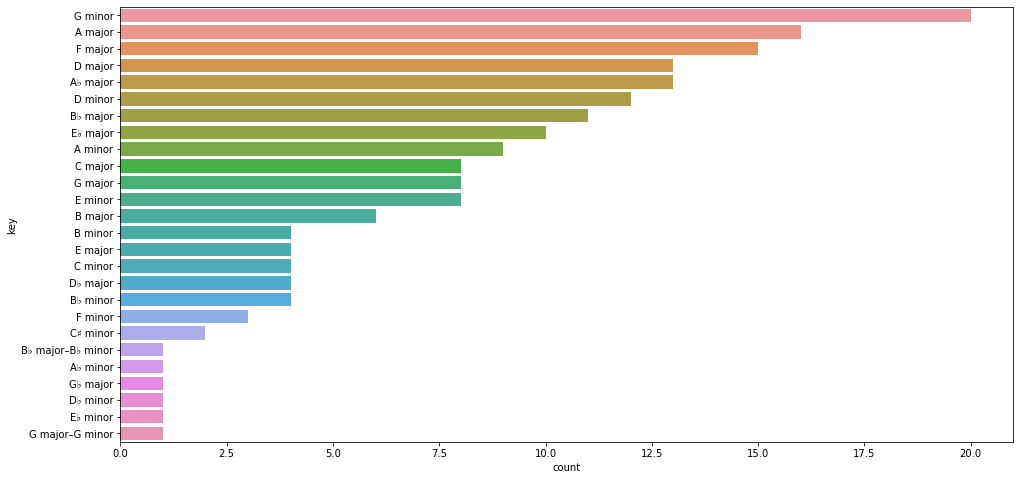

In [22]:
plt.figure(figsize=(16,8))
sns.countplot(y=df['key'], data=df, order = df['key'].value_counts().index)

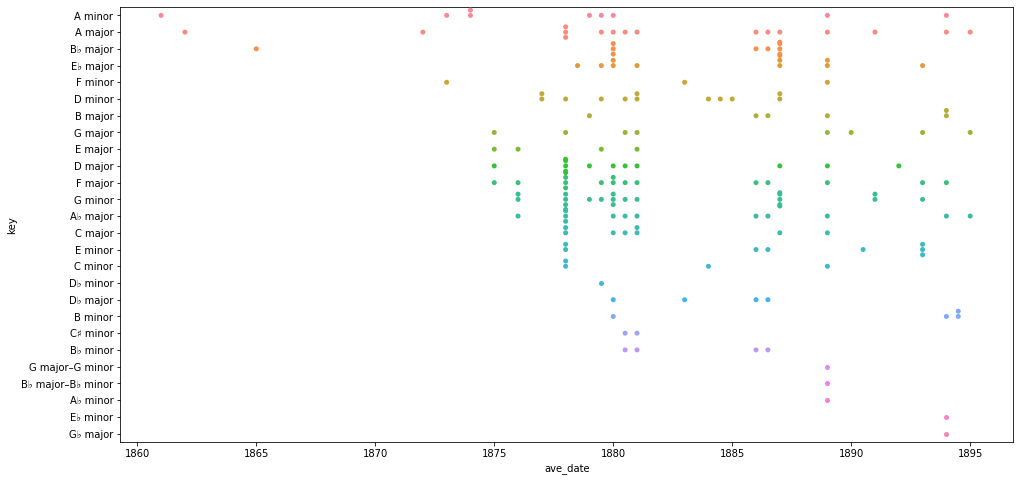

In [23]:
plt.figure(figsize=(16,8))
sns.swarmplot(x=df['ave_date'],y=df['key'])

In [24]:
# Top 1: G minor
df.loc[df['key'] == 'G minor']

,b.,op.,title,forces,key,date,genre,notes,mode,min_date,max_date,ave_date
15,056,026,Piano Trio No.2,vn vc pf,G minor,1876,Chamber,,minor,1876,1876,1876.0
19,063,033,Piano Concerto,pf orch,G minor,1876,Orchestral,,minor,1876,1876,1876.0
32,172/2,046/2,Furiant,vc pf,G minor,1891,Chamber,arr. of B.78/8,minor,1891,1891,1891.0
41,083/8,046/8,Furiant,orch,G minor,1878,Orchestral,2nd version of B.172,minor,1878,1878,1878.0
45,086/2,045/2,Slavonic Rhapsody,orch,G minor,1878,Orchestral,arr. for pf4h as B.506/2,minor,1878,1878,1878.0
48,506/2,045/2,Slavonic Rhapsody,pf4h,G minor,1878,Keyboard,arr. of B.86/2,minor,1878,1878,1878.0
59,101/5,054/5,Waltz,pf,G minor,1879–80,Keyboard,,minor,1879,1880,1879.5
65,110/1,052/1,Impromptu,pf,G minor,1880,Keyboard,arr. for pf4h as B.513/1,minor,1880,1880,1880.0
68,110/4,052/4,Eclogue,pf,G minor,1880,Keyboard,arr. for pf4h as B.513/4,minor,1880,1880,1880.0
69,110/5,052/5,Piano Piece,pf,G minor,1880,Keyboard,arr. for pf4h as B.513/5,minor,1880,1880,1880.0


In [25]:
# Top 2: A major. Piano Quintet, Op. 81 is the most representative work of A mjor.
df.loc[df["key"] == "A major"]

,b.,op.,title,forces,key,date,genre,notes,mode,min_date,max_date,ave_date
1,008,002,String Quartet No.1,2vn va vc,A major,1862,Chamber,,major,1862,1862,1862.0
3,028,005,Piano Quintet,2vn va vc pf,A major,1872,Chamber,,major,1872,1872,1872.0
26,172/1,046/3,Polka,vc pf,A major,1891,Chamber,arr. of B.78/3,major,1891,1891,1891.0
28,078/5,046/5,Skocná,pf4h,A major,1878,Keyboard,,major,1878,1878,1878.0
33,080,048,String Sextet,2vn 2va 2vc,A major,1878,Chamber,,major,1878,1878,1878.0
38,083/5,046/5,Skocná,orch,A major,1878,Orchestral,,major,1878,1878,1878.0
53,101/1,054/1,Waltz,pf,A major,1879–80,Keyboard,arr. for str/(2vn va vc (+db)) as B.105/1,major,1879,1880,1879.5
54,105/1,054/9,Waltz,str/(2vn va vc (+db)),A major,1880,Orchestral,arr. of B.101/1,major,1880,1880,1880.0
90,117/07,059/07,Legend,pf4h,A major,1880–81,Keyboard,,major,1880,1881,1880.5
102,122/7,059/17,Legend,orch,A major,1881,Orchestral,,major,1881,1881,1881.0


In [26]:
# Top 3: F major. String Quartet No.12("American") is his most well-known work.
df.loc[df['key'] == 'F major']

,b.,op.,title,forces,key,date,genre,notes,mode,min_date,max_date,ave_date
14,054,076,Symphony No.5,orch,F major,"1875, rev.1887",Orchestral,"first published as Symphony No.3, Op.24",major,1875,1875,1875.0
18,058/2,028/2,Minuet,pf,F major,1876,Keyboard,,major,1876,1876,1876.0
27,078/4,046/4,Sousedská,pf4h,F major,1878,Keyboard,,major,1878,1878,1878.0
37,083/4,046/4,Sousedská,orch,F major,1878,Orchestral,,major,1878,1878,1878.0
43,085/2,042/2,Furiant,pf,F major,1878,Keyboard,,major,1878,1878,1878.0
60,101/6,054/6,Waltz,pf,F major,1879–80,Keyboard,,major,1879,1880,1879.5
63,106,057,Violin Sonata,vn pf,F major,1880,Chamber,,major,1880,1880,1880.0
80,111/5,056/5,Mazurka,pf,F major,1880,Keyboard,,major,1880,1880,1880.0
91,117/08,059/08,Legend,pf4h,F major,1880–81,Keyboard,,major,1880,1881,1880.5
103,122/8,059/18,Legend,orch,F major,1881,Orchestral,,major,1881,1881,1881.0


### Genre

In [27]:
df['genre'].unique()

array(['Chamber', 'Orchestral', 'Keyboard', 'Vocal'], dtype=object)

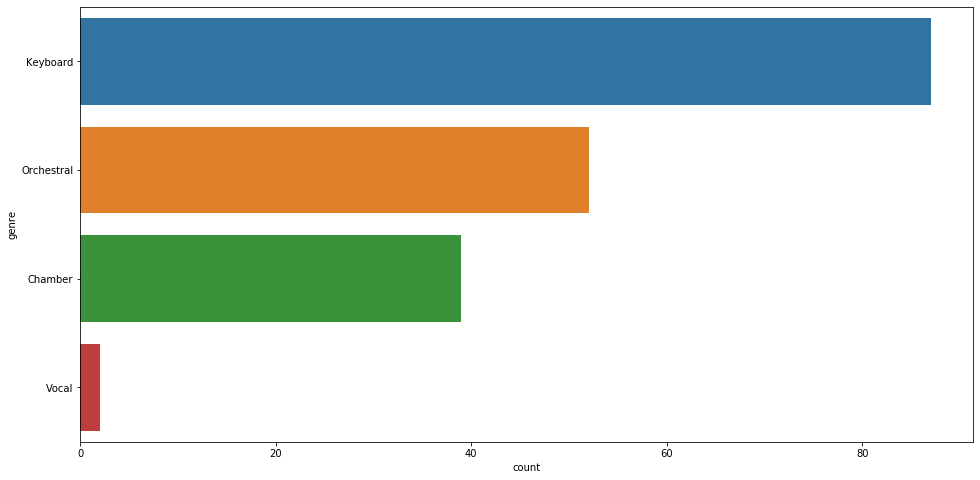

In [28]:
plt.figure(figsize=(16,8))
sns.countplot(y=df['genre'], data=df, order=df['genre'].value_counts().index)

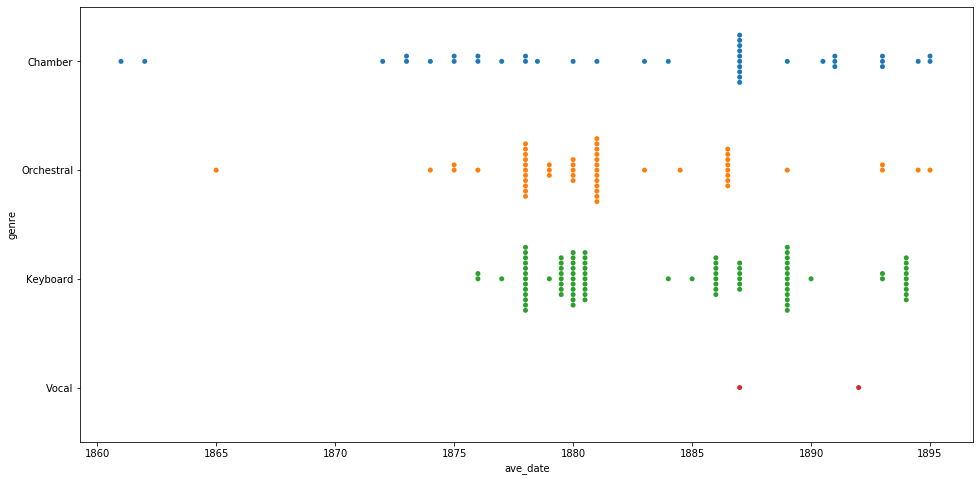

In [29]:
plt.figure(figsize=(16,8))
sns.swarmplot(x=df['ave_date'],y=df['genre'])

### Masterpiece: Piano

In [30]:
df.loc[df['title'].str.contains('Piano', case=False)]

,b.,op.,title,forces,key,date,genre,notes,mode,min_date,max_date,ave_date
3,028,005,Piano Quintet,2vn va vc pf,A major,1872,Chamber,,major,1872,1872,1872.0
13,053,023,Piano Quartet No.1,2vn va vc pf,D major,1875,Chamber,,major,1875,1875,1875.0
15,056,026,Piano Trio No.2,vn vc pf,G minor,1876,Chamber,,minor,1876,1876,1876.0
19,063,033,Piano Concerto,pf orch,G minor,1876,Orchestral,,minor,1876,1876,1876.0
69,110/5,052/5,Piano Piece,pf,G minor,1880,Keyboard,arr. for pf4h as B.513/5,minor,1880,1880,1880.0
70,110/6,052/6,Piano Piece,pf,E♭ major,1880,Keyboard,arr. for pf4h as B.513/6,major,1880,1880,1880.0
75,513/5,052/5,Piano Piece,pf4h,G minor,1887,Keyboard,arr. of B.110/5,minor,1887,1887,1887.0
76,513/6,052/6,Piano Piece,pf4h,E♭ major,1887,Keyboard,arr. of B.110/6,major,1887,1887,1887.0
106,130,065,Piano Trio No.3,vn vc pf,F minor,1883,Chamber,,minor,1883,1883,1883.0
139,155,081,Piano Quintet,2vn va vc pf,A major,1887,Chamber,,major,1887,1887,1887.0


### Masterpiece: String Quartet

In [31]:
df.loc[df['title'].str.contains('String Quartet', case=False)]

,b.,op.,title,forces,key,date,genre,notes,mode,min_date,max_date,ave_date
1,008,002,String Quartet No.1,2vn va vc,A major,1862,Chamber,,major,1862,1862,1862.0
5,037,009,String Quartet No.5,2vn va vc,F minor,1873,Chamber,Andante con moto quasi allegretto reworked as ...,minor,1873,1873,1873.0
6,040,012,String Quartet No.6,2vn va vc,A minor,1873,Chamber,"revised later, omitting Andante appassionato (...",minor,1873,1873,1873.0
9,045,016,String Quartet No.7,2vn va vc,A minor,1874,Chamber,,minor,1874,1874,1874.0
16,057,080,String Quartet No.8,2vn va vc,E major,"1876, rev.1888",Chamber,arr. for pf4h as B.515,major,1876,1876,1876.0
21,075,034,String Quartet No.9,2vn va vc,D minor,"1877, rev.1879",Chamber,,minor,1877,1877,1877.0
50,092,051,String Quartet No.10,2vn va vc,E♭ major,1878–79,Chamber,,major,1878,1879,1878.5
95,121,061,String Quartet No.11,2vn va vc,C major,1881,Chamber,,major,1881,1881,1881.0
163,179,096,"String Quartet No.12(""American"" ; ""Americký"")",2vn va vc,F major,1893,Chamber,,major,1893,1893,1893.0
178,192,106,String Quartet No.13,2vn va vc,G major,1895,Chamber,,major,1895,1895,1895.0


### Masterpiece: Symphony

In [32]:
df.loc[df['title'].str.contains('Symphony', case=False)]

,b.,op.,title,forces,key,date,genre,notes,mode,min_date,max_date,ave_date
2,012,004,Symphony No.2,orch,B♭ major,"1865, rev.1887",Orchestral,,major,1865,1865,1865.0
4,034,010,Symphony No.3,orch,E♭ major,"1873, rev.1887–89",Orchestral,,major,1873,1889,1881.0
7,041,013,Symphony No.4,orch,D minor,"1874, rev.1887–88",Orchestral,,minor,1874,1888,1881.0
14,054,076,Symphony No.5,orch,F major,"1875, rev.1887",Orchestral,"first published as Symphony No.3, Op.24",major,1875,1875,1875.0
82,112,060,Symphony No.6,orch,D major,1880,Orchestral,"first published as Symphony No.1, Op. 58",major,1880,1880,1880.0
111,141,070,Symphony No.7,orch,D minor,1884–85,Orchestral,first published as Symphony No.2; movts. II an...,minor,1884,1885,1884.5
112,512,070,Symphony No.7,pf4h,D minor,1885,Keyboard,arr. of movts. II and III only from B.141,minor,1885,1885,1885.0
154,163,088,Symphony No.8,orch,G major,1889,Orchestral,first published as Symphony No.4; arr. for pf4...,major,1889,1889,1889.0
155,518,088,Symphony No.8,pf4h,G major,1890,Keyboard,arr. of B.163,major,1890,1890,1890.0
161,178,095,"Symphony No.9 (""Fromthe New World"" ; ""Z nového...",orch,E minor,1893,Orchestral,"first published as ""Symphony 5"" ; arr. for pf4...",minor,1893,1893,1893.0
